In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math

In [2]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [3]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
path_pcs = '../Data/PCs_corrected/'

# First compute WRs for ERA5

In [4]:
reanalysis = 'ERA5'
pcs = pd.read_csv(f'../Data/PCs_corrected/PCs_{reanalysis}_v3.csv',
                  index_col=0,parse_dates=True, names=np.arange(0,12),skiprows=1)

In [5]:
pcs

,0,1,2,3,4,5,6,7,8,9,10,11
1940-01-01,1.592570,0.309098,-1.520791,-0.924932,0.482946,0.234610,0.705721,0.623285,-0.638160,-0.761225,0.060444,-1.018460
1940-01-02,1.795961,0.601324,-1.519234,-0.918569,0.225586,0.119289,0.722117,0.901950,-0.796024,-1.131595,-0.332760,-1.154015
1940-01-03,1.759721,0.815316,-1.465746,-0.989952,-0.145709,-0.097874,0.689186,1.179927,-1.044579,-1.243420,-0.452132,-1.339648
1940-01-04,1.464199,0.939107,-1.313157,-1.096079,-0.532340,-0.356364,0.623159,1.407307,-1.366978,-1.122607,-0.292337,-1.530929
1940-01-05,0.953324,0.972126,-1.028814,-1.178661,-0.831383,-0.572394,0.537081,1.555670,-1.706414,-0.847952,0.061810,-1.664301
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.036397,-1.451776,-1.757679,-1.515634,-0.283060,-0.069422,-0.360045,0.347664,-0.152616,2.097094,1.525402,-0.704871
2023-12-28,0.150043,-1.148471,-1.688955,-1.498577,-0.061540,-0.089398,-0.041289,0.291311,-0.303615,1.791564,1.750555,-0.830665
2023-12-29,0.411998,-0.796112,-1.605100,-1.369209,0.220070,-0.001604,0.243951,0.244426,-0.417976,1.238838,1.630291,-0.892570
2023-12-30,0.795203,-0.417679,-1.542485,-1.187941,0.458840,0.129771,0.470530,0.270172,-0.491947,0.539648,1.211762,-0.917016


In [6]:
def compute_wrs(pcs):
    datatransformed = pcs
    ### GET OPTIMAL NUMBER OF CLUSTERS BASED ON INTERCLUSTER CORRELATION ###
    maxcorrs = []
    dbis = []
    # s_scores = []
    
    nclusterslist = np.arange(2,11)
    for inclusters in nclusterslist:
        # train kmeans
        k_means = KMeans(n_clusters=inclusters,
                         init='k-means++',
                         verbose=0,
                         random_state=42)
        k_means.fit(datatransformed)
        clusters_centers = k_means.cluster_centers_
        labels = k_means.labels_
        # Compute the Davies-Bouldin Index
        dbi = davies_bouldin_score(datatransformed, labels)
        # s_score = silhouette_score(datatransformed, labels)
        
        dbis.append(dbi)
        # s_scores.append(s_score)
        # Compute the maximum correlation
        correlation_matrix = np.corrcoef(clusters_centers)
        np.fill_diagonal(correlation_matrix, np.nan)
        maxcorr = np.nanmax(correlation_matrix)
        maxcorrs.append(maxcorr)

    ## Compute K-means with best number of clusters
    maxcorrs_neg = np.array(maxcorrs)
    maxcorrs_neg[maxcorrs_neg>=0] = np.nan
    
    best_n = nclusterslist[np.min([np.argmin(dbis),np.nanargmax(maxcorrs_neg)])]
    
    # train kmeans
    k_means = KMeans(n_clusters=best_n,
                     init='k-means++',
                     verbose=0,
                     random_state=42)
    k_means.fit(datatransformed)
    clusters_centers = k_means.cluster_centers_
    labels = k_means.labels_
    distances = euclidean_distances(clusters_centers, datatransformed)

    # return datatransformed, clusters_centers, labels, distances, dbis, maxcorrs, s_scores, variance_explained
    return clusters_centers, labels, distances, dbis, maxcorrs

In [7]:
clusters_centers, labels, distances, dbis, maxcorrs = compute_wrs(pcs)

In [8]:
path_figures = '../Figures_v4/'

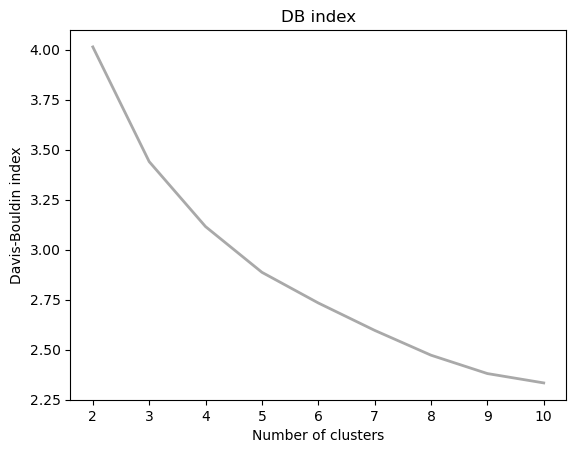

In [9]:
plt.plot(np.arange(2,11),dbis,color='darkgray',lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('Davis-Bouldin index')
plt.title('DB index')
plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

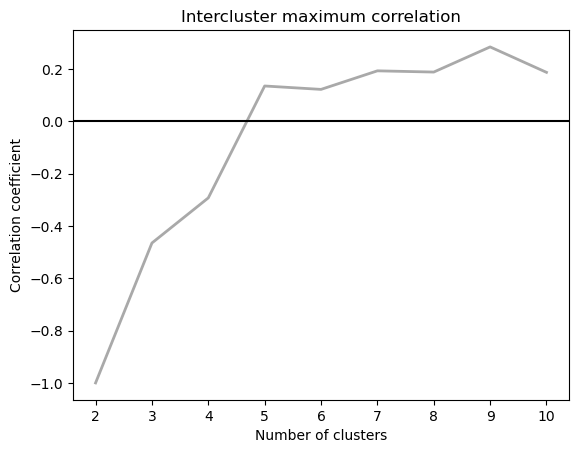

In [10]:
plt.plot(np.arange(2,11),maxcorrs,color='darkgray',lw=2)

plt.axhline(0,color='k')
plt.xlabel('Number of clusters')
plt.ylabel('Correlation coefficient')
plt.title('Intercluster maximum correlation')
plt.savefig(f'{path_figures}Corr.png',bbox_inches='tight')

In [12]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 verbose=1,
                 random_state=42)
k_means.fit(pcs.values)
clusters_centers = k_means.cluster_centers_
labels = k_means.labels_

Initialization complete
Iteration 0, inertia 464759.22349300096.
Iteration 1, inertia 326251.0196381954.
Iteration 2, inertia 324851.5503485846.
Iteration 3, inertia 324321.86178015923.
Iteration 4, inertia 324038.4600655146.
Iteration 5, inertia 323823.2663010423.
Iteration 6, inertia 323636.38359637314.
Iteration 7, inertia 323454.21572853904.
Iteration 8, inertia 323303.0140313394.
Iteration 9, inertia 323167.04360220657.
Iteration 10, inertia 323022.3112644831.
Iteration 11, inertia 322852.47890931607.
Iteration 12, inertia 322676.1657636252.
Iteration 13, inertia 322510.70281876466.
Iteration 14, inertia 322337.48798824626.
Iteration 15, inertia 322168.5154779234.
Iteration 16, inertia 322009.8276129735.
Iteration 17, inertia 321866.02758879325.
Iteration 18, inertia 321729.1086728028.
Iteration 19, inertia 321604.90975945885.
Iteration 20, inertia 321502.6233876413.
Iteration 21, inertia 321418.3317820395.
Iteration 22, inertia 321347.490684911.
Iteration 23, inertia 321291.51241

In [13]:
with open('../Data_v4/k_means_model_era5_v4.pkl','wb') as f:
    pickle.dump(k_means,f)

In [15]:
cluster_centers = np.vstack([clusters_centers,np.zeros(12)])
distances = euclidean_distances(cluster_centers, pcs.values)
new_labels = distances.argmin(axis=0)
df_labels = pd.DataFrame(new_labels,index=pcs.index)

In [16]:
df_labels.columns=['WR']

In [17]:
df_labels['distances'] = distances.min(axis=0)

In [18]:
df_labels.to_csv(f'../Data_v4/Labels/df_labels_{reanalysis}_v4.csv')

# WRs for the other reanalyses

In [19]:
for reanalysis in names_reanalyses[1:]:
    pcs = pd.read_csv(f'../Data/PCs_corrected/PCs_{reanalysis}_v3.csv',
        index_col=0,parse_dates=True, names=np.arange(0,12),skiprows=1)
    distances = euclidean_distances(cluster_centers, pcs.values)
    new_labels = distances.argmin(axis=0)
    df_labels = pd.DataFrame(new_labels,index=pcs.index)
    df_labels.columns=['WR']
    df_labels['distances'] = distances.min(axis=0)
    df_labels.to_csv(f'../Data_v4/Labels/df_labels_{reanalysis}_v4.csv')

# Accuracy among reanalyses

In [20]:
import seaborn as sns

In [21]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data_v3/Labels/df_labels_{reanalysis}_v3.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances'], skiprows=1)
    dic_labels[reanalysis] = labels_temp[['WR']]


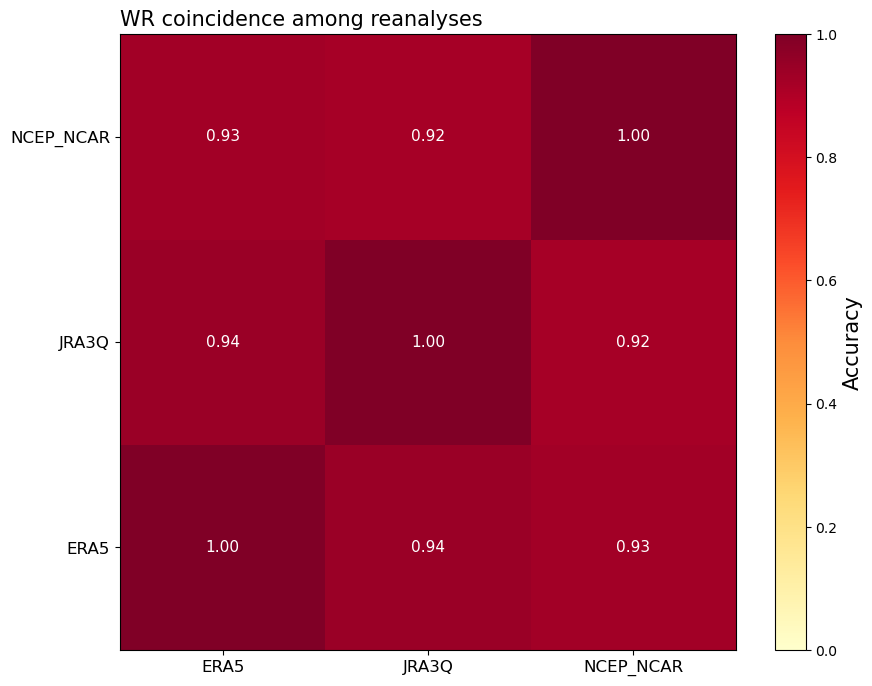

In [22]:
# Function to compute accuracy
def compute_accuracy(series1, series2):
    return np.mean(series1 == series2)

# Function to align and compute accuracy matrix
def compute_accuracy_matrix():
    df_combined = pd.DataFrame()
    accuracy_matrix = pd.DataFrame(index=names_reanalyses, columns=names_reanalyses)
    
    for i, reanalysis1 in enumerate(names_reanalyses):
        for j, reanalysis2 in enumerate(names_reanalyses):
            if i <= j:  # Compute only for upper triangle and diagonal
                df_combined = pd.concat([dic_labels[reanalysis1], dic_labels[reanalysis2]], axis=1, join='inner').dropna()
                accuracy = compute_accuracy(df_combined.iloc[:, 0], df_combined.iloc[:, 1])
                accuracy_matrix.loc[reanalysis1, reanalysis2] = accuracy
                accuracy_matrix.loc[reanalysis2, reanalysis1] = accuracy  # Mirror value to lower triangle
    
    return accuracy_matrix.astype(float)

# Compute and plot accuracy matrix
accuracy_matrix = compute_accuracy_matrix()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(accuracy_matrix, cmap='YlOrRd', vmin=0, vmax=1, origin='lower',)

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Accuracy', fontsize=15)  # Set colorbar label and fontsize

# Set ticks and labels
ax.set_xticks(np.arange(len(names_reanalyses)))
ax.set_yticks(np.arange(len(names_reanalyses)))
ax.set_xticklabels(names_reanalyses, fontsize=12)
ax.set_yticklabels(names_reanalyses, fontsize=12)

# Set x-axis ticks position to bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')

# # Rotate the x tick labels if necessary
# plt.xticks(rotation=90)

# Add annotations
for i in range(len(names_reanalyses)):
    for j in range(len(names_reanalyses)):
        text = ax.text(j, i, f'{accuracy_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='white',fontsize=11)

plt.title('WR coincidence among reanalyses', fontsize=15,loc='left')
plt.savefig('../Figures_v4/CoincidenceAmongWRs_v3.png',bbox_inches='tight')

# Compute composites

In [23]:
def get_average_fields_for_centroids(dataarray,labels):
    wrs = np.unique(labels)
    avgs = []
    for wr in wrs:
        df_wr = labels[labels['WR']==wr]
        arr_selection = dataarray.sel(time=df_wr.index)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return xr.concat(avgs,dim='WR')

In [24]:
for reanalysis in names_reanalyses:
    anoms = xr.open_dataset(f'{path_anoms}Z500FiltAnoms_{reanalysis}_v3.nc')
    labels_temp = pd.read_csv(f'../Data_v4/Labels/df_labels_{reanalysis}_v4.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances'], skiprows=1)[['WR']]
    composites = get_average_fields_for_centroids(anoms, labels_temp)
    composites.to_netcdf(f'../Data_v4/Composites/Composites_{reanalysis}_v4.nc')

In [25]:
del(anoms)

# Plot composites

In [26]:
def plot_composite_grid(dic_composites, dic_freqs, regioncoords, names=None, n_cols=3, path_save=None):
    min_lon, max_lon, min_lat, max_lat = regioncoords
    n_reanalyses = len(dic_composites)
    n_clusters = len(dic_composites[list(dic_composites.keys())[0]].WR)-1
    
    # Determine the number of rows needed
    n_rows = n_clusters
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 1.5 * n_rows),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
    
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each reanalysis in the grid
    letter_idx = 0  # Start the letter index
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            reanalysis = list(dic_composites.keys())[j]
            da = dic_composites[reanalysis]
            freqs_labels = dic_freqs[reanalysis]
            
            # Convert longitudes to -180 to 180 range
            lon = (da.lon + 180) % 360 - 180
            
            # Adjust data array to match the longitude range
            da_shifted, lon_shifted = xr.broadcast(da, lon)
            
            # Plot the rectangle to highlight the specified region
            rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha': 0.2}
            if min_lon < max_lon:
                ax.add_patch(plt.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                                           transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            else:
                ax.add_patch(plt.Rectangle((min_lon, min_lat), 180 - min_lon, max_lat - min_lat,
                                           transform=ccrs.PlateCarree(), **rect_style, zorder=2))
                ax.add_patch(plt.Rectangle((-180, min_lat), max_lon + 180, max_lat - min_lat,
                                           transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            
            ax.set_extent([-100, 90, 10, 90], crs=ccrs.PlateCarree(central_longitude=-100))
            
            # Add gridlines every 20 degrees
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
            gl.xlocator = plt.FixedLocator(np.arange(-180, 180, 30))
            gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LongitudeFormatter(zero_direction_label=True)
            gl.yformatter = LatitudeFormatter()
            
            tick_fontsize = 8
            gl.xlabel_style = {'size': tick_fontsize}
            gl.ylabel_style = {'size': tick_fontsize}
            
            mini=-2.5
            maxi=2.5
            intervals = 21
            bounds=np.linspace(mini,maxi,intervals)
            
            # Plot the data using pcolormesh
            mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anomalies.values,
                               levels=bounds, vmin=mini, vmax=maxi,
                                cmap='RdYlBu_r', transform=ccrs.PlateCarree(),extend='both')
            
            # Add coastlines for context
            ax.coastlines()

            # Generate the letter for the current subplot
            letter = chr(97 + letter_idx)  # 'a' = 97 in ASCII
            letter_idx += 1

            if names:
                ax.set_title(f'({letter}) {names[i]} - Freq.: {np.round(freqs_labels[i], 2)}%', fontsize=10, loc='left')
            else:
                ax.set_title(f'({letter}) Cluster {i+1} - Freq.: {np.round(freqs_labels[i], 2)}%', fontsize=10, loc='left')
    
    # Add reanalysis names as column titles
    letter_idx = 0
    for j, reanalysis in enumerate(dic_composites.keys()):
        freqs_labels = dic_freqs[reanalysis]
        letter = chr(97 + letter_idx)  # 'a' = 97 in ASCII
        letter_idx += 1
        axes[0, j].set_title(f'{reanalysis}\n({letter}) {names[0]} - Freq.: {np.round(freqs_labels[0], 2)}%', fontsize=10, loc='left')
    
    plt.tight_layout()
    
    # Add a horizontal colorbar for all subplots
    cax = fig.add_axes([0.3, -0.02, 0.4, 0.02])
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')
    
    if path_save:
        plt.savefig(path_save, bbox_inches='tight', dpi=200)
    else:
        plt.show()
        plt.close('all')

In [30]:
dic_composites = {}
dic_frequencies = {}

for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data_v4/Labels/df_labels_{reanalysis}_v4.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances'], skiprows=1)[['WR']]
    composites = xr.open_dataset(f'../Data_v4/Composites/Composites_{reanalysis}_v4.nc')
    frequencies_percent = labels_temp['WR'].value_counts(normalize=True) * 100
    frequencies_percent = frequencies_percent.sort_index().values
    dic_frequencies[reanalysis] = frequencies_percent
    dic_composites[reanalysis] = composites
region = [180, 330, 20, 80]
names = ["Pacific High","Pacific Trough","Greenland High","Atlantic High","No WR"]
# names = ["Greenland High", "Alaskan Ridge", "Pacific High", "Atlantic High", "Pacific Trough" ,"No WR"]

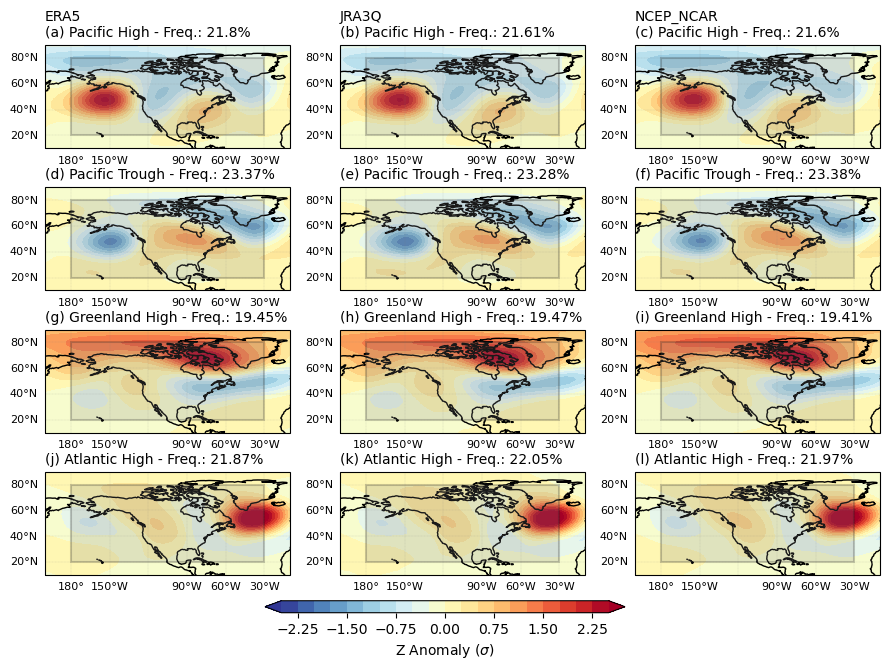

In [31]:
# Example usage:
plot_composite_grid(dic_composites, dic_frequencies, regioncoords=region,
                    names=names,path_save=f'{path_figures}Composites_All_v3.png')

In [37]:
def plot_multiple_maps(da,freqs_labels,regioncoords,names = None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da.WR)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(da.WR.values)-1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)
        
        # Plot the rectangle to highlight the specified region
        rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha':0.2}
        
        if min_lon_converted < max_lon_converted:
            # Normal case, region does not cross the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), max_lon_converted - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
        else:
            # Special case for regions crossing the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), 180 - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            ax.add_patch(plt.Rectangle(
                (-180, min_lat), max_lon_converted + 180, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))

        ax.set_extent([-100, 100, 10, 90], crs=ccrs.PlateCarree(central_longitude=-100))

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-2.5
        maxi=2.5
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anomalies.values, levels=bounds, vmin=mini, vmax=maxi,
                                 cmap='RdYlBu_r', transform=ccrs.PlateCarree(),extend='both')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.3, 0.22, 0.4, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if path_save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=100)
        plt.close('all')

In [38]:
plot_multiple_maps(dic_composites['ERA5'],dic_frequencies['ERA5'],
                   region,names=names, path_save=f'{path_figures}/Composites_ERA5_v3.png')

# Seasonal Frequency

In [39]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

In [41]:
dic_labels = {}

for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data_v4/Labels/df_labels_{reanalysis}_v4.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances'], skiprows=1)[['WR']]
    dic_labels[reanalysis] = labels_temp

In [42]:
colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

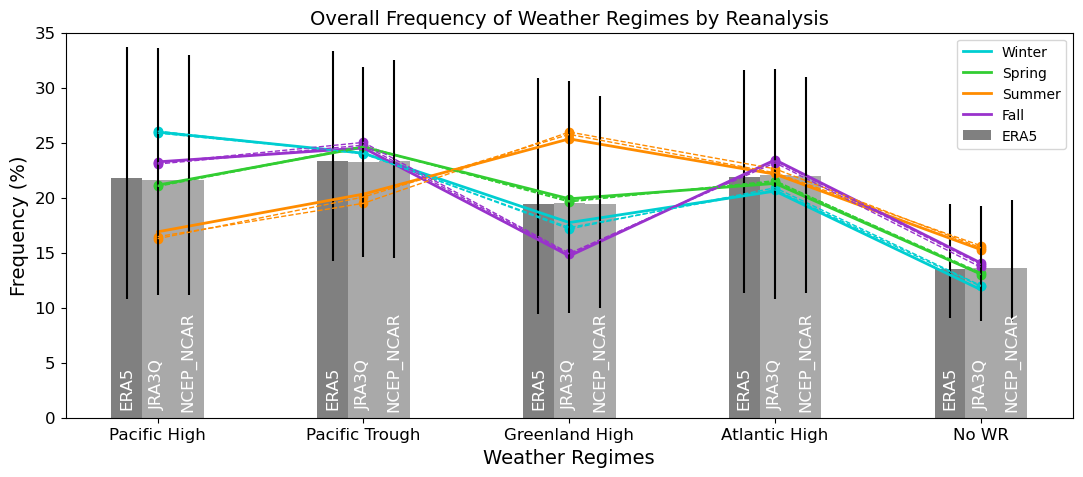

In [43]:
# Function to plot the bars and lines using an axes object
def plot_frequency(ax, names, dic_labels, names_reanalyses, seasons, colors_seasons):
    # Define a color palette or use specific colors for each reanalysis
    colors = ['gray', 'darkgray', 'darkgray', 'darkgray', 'darkgray']  # Adjust as needed

    bar_width = 0.15  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups

    for ir, reanalysis in enumerate(names_reanalyses):
        # print(ir)
        # Compute Overall Frequency of Each Class
        df_labels = copy.deepcopy(dic_labels[reanalysis])
        overall_frequency = df_labels.value_counts().sort_index()
        # Compute year-by-year frequencies
        yearly_freqs = df_labels.groupby(df_labels.index.year).apply(lambda x: x.value_counts().sort_index())
        # if reanalysis == 'ERA5':
        #     yearly_freqs = yearly_freqs.unstack(fill_value=0)
        # print(yearly_freqs)
        yearly_freqs_percent = yearly_freqs.div(yearly_freqs.sum(axis=1), axis=0) * 100

        # Calculate the 95th and 5th percentiles for each weather regime
        percentiles_95 = yearly_freqs_percent.quantile(0.95, axis=0)
        percentiles_5 = yearly_freqs_percent.quantile(0.05, axis=0)

        
        df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
        # Map season numbers to season names
        season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
        df_labels['season'] = df_labels['season'].map(season_map)
        # Group by season and class to count the frequency
        seasonal_frequency = df_labels.groupby(['season', 'WR']).size().unstack(fill_value=0)
        # To display as percentage per season
        seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100

        # Plot bars for this reanalysis
        if reanalysis == 'ERA5':
            ax.bar(x + ir * bar_width, 100 * overall_frequency / np.sum(overall_frequency), 
                   width=bar_width, color=colors[ir], label=reanalysis)
        else:
            ax.bar(x + ir * bar_width, 100 * overall_frequency / np.sum(overall_frequency), 
                   width=bar_width, color=colors[ir])
        
        # Add text labels on top of the bars
        for i, freq in enumerate(overall_frequency):
            ax.text(x[i] + ir * bar_width, 1, 
                    f'{reanalysis}', ha='center', fontsize=12, rotation=90, color='white')
        # print(yearly_freqs)
        # print(x + ir * bar_width)
        # print(percentiles_5)
        # Plot the 95th and 5th percentiles as error bars
        ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5)

        # Plot seasonal percentages
        if reanalysis == 'ERA5':
            for iseason in range(len(seasons)):
                ax.plot(x + 0.15, seasonal_percentage.loc[seasons[iseason]], color=colors_seasons[iseason],
                        lw=2, label=seasons[iseason])
                ax.scatter(x + 0.15, seasonal_percentage.loc[seasons[iseason]], color=colors_seasons[iseason])
        else:
            for iseason in range(len(seasons)):
                ax.plot(x + 0.15, seasonal_percentage.loc[seasons[iseason]], color=colors_seasons[iseason],
                        lw=1, ls='--')
                ax.scatter(x + 0.15, seasonal_percentage.loc[seasons[iseason]], color=colors_seasons[iseason])

    # Set x-ticks and labels
    ax.set_xticks(x + bar_width * (len(names_reanalyses) - 1) / 2)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    ax.set_yticks(np.arange(0, 36, 5))
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(0, 35)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Frequency (%)', fontsize=14)
    ax.set_title('Overall Frequency of Weather Regimes by Reanalysis', fontsize=14)
    ax.legend()
## Days per season
# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_frequency(ax, names, dic_labels, names_reanalyses, seasons, colors_seasons)
plt.savefig(f'{path_figures}/SeasonalFrequencies_v3.png',bbox_inches='tight')

# Eventwise analysis

In [44]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    
    dic_events[reanalysis] = df_events

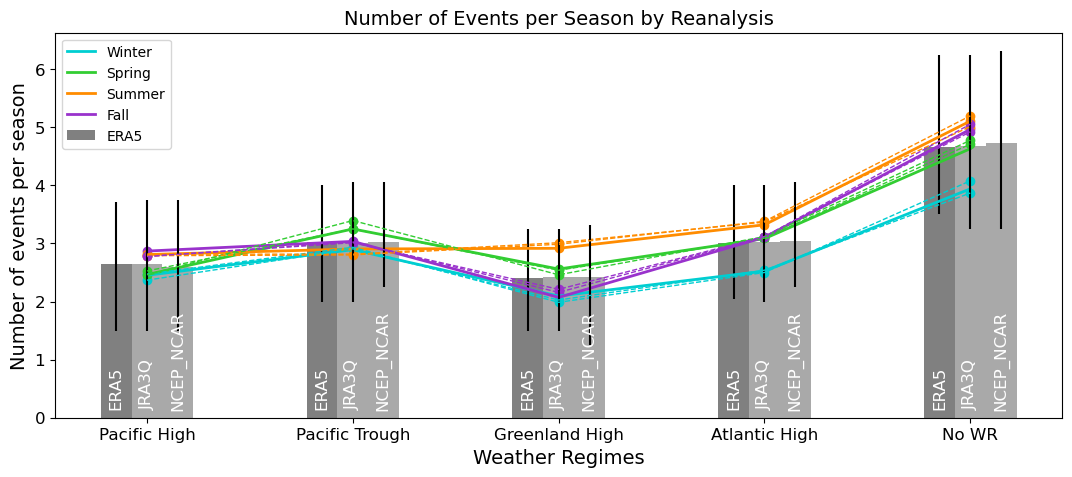

In [45]:
# Function to plot the bars and lines using an axes object
def plot_eventwise_frequency(ax, names, dic_events, names_reanalyses, seasons, colors_seasons):
    # Define a color palette or use specific colors for each reanalysis
    colors = ['gray', 'darkgray', 'darkgray', 'darkgray', 'darkgray']  # Adjust as needed

    bar_width = 0.15  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups

    for ir, reanalysis in enumerate(names_reanalyses):
        ### CALCULATIONS
        df_events = copy.deepcopy(dic_events[reanalysis])
        # Total number of events for each class
        total_events_per_class = df_events.groupby('WR').size()
        # Extract the years from the 'start_date' index
        df_events['year'] = df_events.index.year
        # Calculate the number of unique years in the dataset
        total_years = df_events['year'].nunique()
        # Calculate the average frequency of events per year for each class
        average_frequency_per_year = total_events_per_class / total_years

        # Calculate the yearly number of events
        yearly_events = df_events.groupby(['year', 'WR']).size().unstack(fill_value=0)
        yearly_events_percent = yearly_events.div(yearly_events.sum(axis=1), axis=0) * 100
        
        # Calculate the 95th and 5th percentiles for the yearly number of events
        percentiles_95 = yearly_events.quantile(0.95, axis=0)
        percentiles_5 = yearly_events.quantile(0.05, axis=0)

        # Calculate the number of events for each class per season
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            elif month in [9, 10, 11]:
                return 'Fall'

        # Add a 'season' column to the DataFrame
        df_events['season'] = df_events.index.month.map(get_season)
        events_per_season = df_events.groupby(['WR', 'season']).size().unstack(fill_value=0)
        # Calculate the average frequency of events per season for each class
        average_frequency_per_season = events_per_season / total_years
        average_frequency_per_season = average_frequency_per_season[seasons]

        ### PLOTTING
        # Plot bars for this reanalysis
        if reanalysis == 'ERA5':
            ax.bar(x + ir * bar_width, average_frequency_per_year / 4, 
                   width=bar_width, color=colors[ir], label=reanalysis)
        else:
            ax.bar(x + ir * bar_width, average_frequency_per_year / 4, 
                   width=bar_width, color=colors[ir])
        
        # Add text labels on top of the bars
        for i, freq in enumerate(average_frequency_per_year):
            ax.text(x[i] + ir * bar_width, 0.2, 
                    f'{reanalysis}', ha='center', fontsize=12, rotation=90, color='white')

        # Plot the 95th and 5th percentiles as error bars
        ax.vlines(x + ir * bar_width, percentiles_5/4, percentiles_95/4, color='k', lw=1.5)

        # Plot seasonal frequencies
        if reanalysis == 'ERA5':
            for iseason in range(len(seasons)):
                ax.plot(x + 0.15, average_frequency_per_season[seasons[iseason]], color=colors_seasons[iseason],
                        lw=2, label=seasons[iseason])
                ax.scatter(x + 0.15, average_frequency_per_season[seasons[iseason]], color=colors_seasons[iseason])
        else:
            for iseason in range(len(seasons)):
                ax.plot(x + 0.15, average_frequency_per_season[seasons[iseason]], color=colors_seasons[iseason],
                        lw=1, ls='--')
                ax.scatter(x + 0.15, average_frequency_per_season[seasons[iseason]], color=colors_seasons[iseason])

    # Set x-ticks and labels
    ax.set_xticks(x + bar_width * (len(names_reanalyses) - 1) / 2)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Number of events per season', fontsize=14)
    ax.set_title('Number of Events per Season by Reanalysis', fontsize=14)
    ax.legend()

# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_eventwise_frequency(ax, names, dic_events, names_reanalyses, seasons, colors_seasons)
plt.savefig(f'{path_figures}/SeasonalNEvents_v3.png',bbox_inches='tight')

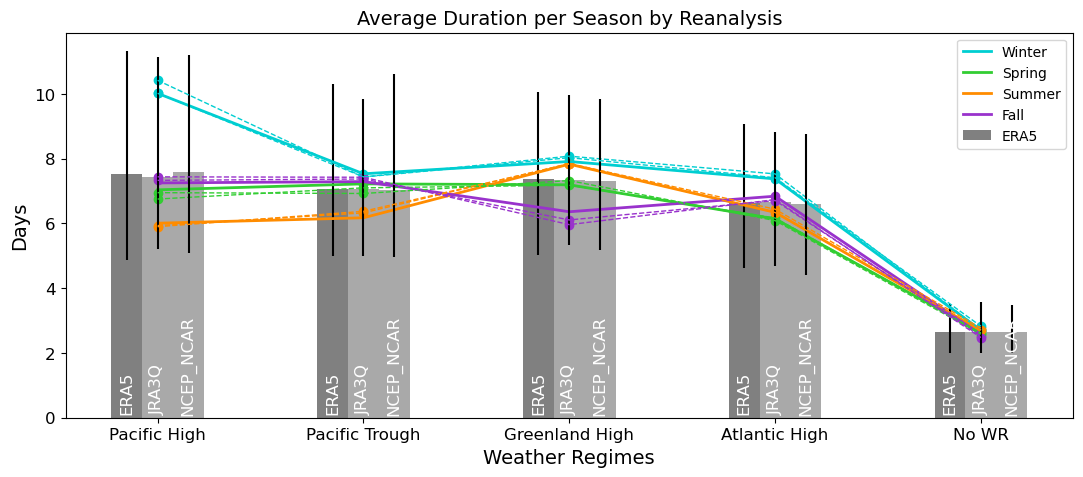

In [46]:
# Function to plot the bars and lines using an axes object
def plot_eventwise_duration(ax, names, dic_events, names_reanalyses, seasons, colors_seasons):
    # Define a color palette or use specific colors for each reanalysis
    colors = ['gray', 'darkgray', 'darkgray', 'darkgray', 'darkgray']  # Adjust as needed

    bar_width = 0.15  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups

    for ir, reanalysis in enumerate(names_reanalyses):
        ### CALCULATIONS
        df_events = copy.deepcopy(dic_events[reanalysis])
        # Calculate the mean duration overall for each class
        mean_duration_overall = df_events.groupby('WR')['duration'].mean()

        # Extract the years from the 'start_date' index
        df_events['year'] = df_events.index.year

        # Calculate the yearly average duration
        yearly_duration = df_events.groupby(['year', 'WR'])['duration'].mean().unstack(fill_value=0)

        # Calculate the 95th and 5th percentiles for the yearly average duration
        percentiles_95 = yearly_duration.quantile(0.95, axis=0)
        percentiles_5 = yearly_duration.quantile(0.05, axis=0)

        # Define seasons as a dictionary mapping month to season
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            elif month in [9, 10, 11]:
                return 'Fall'

        # Add a 'season' column to the DataFrame
        df_events['season'] = df_events.index.month.map(get_season)
        mean_duration_by_season = df_events.groupby(['season', 'WR'])['duration'].mean()

        ### PLOTTING
        # Plot bars for this reanalysis
        if reanalysis == 'ERA5':
            ax.bar(x + ir * bar_width, mean_duration_overall, 
                   width=bar_width, color=colors[ir], label=reanalysis)
        else:
            ax.bar(x + ir * bar_width, mean_duration_overall, 
                   width=bar_width, color=colors[ir])

        # Add text labels on top of the bars
        for i, duration in enumerate(mean_duration_overall):
            ax.text(x[i] + ir * bar_width, 0.2, 
                    f'{reanalysis}', ha='center', fontsize=12, rotation=90, color='white')

        # Plot the 95th and 5th percentiles as error bars
        ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5)

        # Plot seasonal durations
        if reanalysis == 'ERA5':
            for iseason in range(len(seasons)):
                ax.plot(x + 0.15, mean_duration_by_season[seasons[iseason]], color=colors_seasons[iseason],
                        lw=2, label=seasons[iseason])
                ax.scatter(x + 0.15, mean_duration_by_season[seasons[iseason]], color=colors_seasons[iseason])
        else:
            for iseason in range(len(seasons)):
                ax.plot(x + 0.15, mean_duration_by_season[seasons[iseason]], color=colors_seasons[iseason],
                        lw=1, ls='--')
                ax.scatter(x + 0.15, mean_duration_by_season[seasons[iseason]], color=colors_seasons[iseason])

    # Set x-ticks and labels
    ax.set_xticks(x + bar_width * (len(names_reanalyses) - 1) / 2)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Days', fontsize=14)
    ax.set_title('Average Duration per Season by Reanalysis', fontsize=14)
    ax.legend()

# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_eventwise_duration(ax, names, dic_events, names_reanalyses, seasons, colors_seasons)
plt.savefig(f'{path_figures}/SeasonalDuration_v3.png',bbox_inches='tight')